In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Add, Dropout, Flatten, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import activations, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as kb
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from time import *
user_balance = pd.read_csv('./user_balance_table.csv')

In [2]:
df_tmp = user_balance.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()
df_tmp.index = pd.to_datetime(df_tmp.index, format='%Y%m%d')

C:\Users\langbo\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [3]:
holidays = ('20130813', '20130902', '20131001', '20131111', '20130919', '20131225', '20140101', '20140130', '20140131',
           '20140214', '20140405', '20140501', '20140602', '20140802', '20140901', '20140908')
def create_features(timeindex):
    n = len(timeindex)
    features = np.zeros((n, 4))
    features[:, 0] = timeindex.day.values/31
    features[:, 1] = timeindex.month.values/12
    features[:, 2] = timeindex.weekday.values/6
    for i in range(n):
        if timeindex[i].strftime('%Y%m%d') in holidays:
            features[i, 3] = 1
    return features

In [4]:
features = create_features(df_tmp.index)
september = pd.to_datetime(['201409%02d' % i for i in range(1, 31)])
features_sep = create_features(september)

In [5]:
scaler_pur = MinMaxScaler()
scaler_red = MinMaxScaler()
data_pur = scaler_pur.fit_transform(df_tmp.values[:, 0:1])
data_red = scaler_red.fit_transform(df_tmp.values[:, 1:2])

In [6]:
def create_dataset(data, back, forward=30):
    n_samples = len(data) - back - forward + 1
    X, Y = np.zeros((n_samples, back, data.shape[-1])), np.zeros((n_samples, forward, data.shape[-1]))
    for i in range(n_samples):
        X[i, ...] = data[i:i+back, :]
        Y[i, ...] = data[i+back:i+back+forward, :]
    return X, Y

In [7]:
def build_cnn(X_trn, lr, n_outputs, dropout_rate):
    inputs = Input(X_trn.shape[1:])
    z = Conv1D(64, 14, padding='valid', activation='relu', kernel_initializer='he_uniform')(inputs)
#     z = MaxPooling1D(2)(z)
    z = Conv1D(128, 7, padding='valid', activation='relu', kernel_initializer='he_uniform')(z)
    z = MaxPooling1D(2)(z)
    z = Conv1D(256, 3, padding='valid', activation='relu', kernel_initializer='he_uniform')(z)
    z = Conv1D(256, 3, padding='valid', activation='relu', kernel_initializer='he_uniform')(z)
    z = MaxPooling1D(2)(z)
    z = Flatten()(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(128, activation='relu', kernel_initializer='he_uniform')(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(84, activation='relu', kernel_initializer='he_uniform')(z)
    outputs = Dense(n_outputs)(z)
    model = Model(inputs=inputs, outputs=outputs)
    adam = optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=adam, metrics=['mae'])
    model.summary()
    return model

In [8]:
back = 60
forward = 30
X_pur_data, Y_pur_data = create_dataset(data_pur, back, forward)
X_red_data, Y_red_data = create_dataset(data_red, back, forward)
X_features, Y_features = create_dataset(features, back, forward)
Y_features = np.concatenate((Y_features, np.zeros((Y_features.shape[0], back-forward, Y_features.shape[-1]))), axis=1)
# X_pur, X_red = np.concatenate((X_pur_data, X_features, Y_features), axis=-1), np.concatenate((X_red_data, X_features, Y_features), axis=-1)
# X_pur_trn, X_pur_val, X_red_trn, X_red_val = X_pur[:-forward, ...], X_pur[-1:, ...], X_red[:-forward, ...], X_red[-1:, ...]
# Y_pur_trn, Y_pur_val, Y_red_trn, Y_red_val = Y_pur_data[:-forward, ...], Y_pur_data[-1:, ...], Y_red_data[:-forward, ...], Y_red_data[-1:, ...]
Y_fea_sep = np.concatenate((features_sep, np.zeros((back-forward, features_sep.shape[-1]))), axis=0)
# X_pur_tst = np.concatenate((data_pur[-back:, :], features[-back:, :], Y_fea_sep), axis=-1)[None, ...]
# X_red_tst = np.concatenate((data_red[-back:, :], features[-back:, :], Y_fea_sep), axis=-1)[None, ...]
X = np.concatenate((X_pur_data, X_red_data, X_features, Y_features), axis=-1)
Y = np.concatenate((Y_pur_data, Y_red_data), axis=1)
X_trn, X_val, Y_trn, Y_val = X[:-forward, ...], X[-1:, ...], Y[:-forward, ...], Y[-1:, ...]
X_tst = np.concatenate((data_pur[-back:, :], data_red[-back:, :], features[-back:, :], Y_fea_sep), axis=-1)[None, ...]

In [10]:
cnn = build_cnn(X_trn, lr=0.0008, n_outputs=2*forward, dropout_rate=0.5)
history = cnn.fit(X_trn, Y_trn, batch_size=32, epochs=1000, verbose=2, 
                      validation_data=(X_val, Y_val),
                     callbacks=[EarlyStopping(monitor='val_mae', patience=200, restore_best_weights=True)])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 10)]          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 47, 64)            9024      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 41, 128)           57472     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 18, 256)           98560     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 16, 256)           196864    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 256)            0   

Epoch 69/1000
10/10 - 0s - loss: 0.0143 - mae: 0.0857 - val_loss: 0.0078 - val_mae: 0.0657
Epoch 70/1000
10/10 - 0s - loss: 0.0142 - mae: 0.0856 - val_loss: 0.0077 - val_mae: 0.0634
Epoch 71/1000
10/10 - 0s - loss: 0.0142 - mae: 0.0853 - val_loss: 0.0078 - val_mae: 0.0662
Epoch 72/1000
10/10 - 0s - loss: 0.0143 - mae: 0.0855 - val_loss: 0.0077 - val_mae: 0.0662
Epoch 73/1000
10/10 - 0s - loss: 0.0141 - mae: 0.0851 - val_loss: 0.0077 - val_mae: 0.0646
Epoch 74/1000
10/10 - 0s - loss: 0.0138 - mae: 0.0840 - val_loss: 0.0074 - val_mae: 0.0630
Epoch 75/1000
10/10 - 0s - loss: 0.0135 - mae: 0.0840 - val_loss: 0.0079 - val_mae: 0.0639
Epoch 76/1000
10/10 - 0s - loss: 0.0139 - mae: 0.0845 - val_loss: 0.0079 - val_mae: 0.0639
Epoch 77/1000
10/10 - 0s - loss: 0.0137 - mae: 0.0843 - val_loss: 0.0077 - val_mae: 0.0621
Epoch 78/1000
10/10 - 0s - loss: 0.0137 - mae: 0.0832 - val_loss: 0.0077 - val_mae: 0.0642
Epoch 79/1000
10/10 - 0s - loss: 0.0132 - mae: 0.0823 - val_loss: 0.0075 - val_mae: 0.0638

Epoch 159/1000
10/10 - 0s - loss: 0.0102 - mae: 0.0728 - val_loss: 0.0083 - val_mae: 0.0662
Epoch 160/1000
10/10 - 0s - loss: 0.0102 - mae: 0.0734 - val_loss: 0.0079 - val_mae: 0.0645
Epoch 161/1000
10/10 - 0s - loss: 0.0101 - mae: 0.0727 - val_loss: 0.0076 - val_mae: 0.0629
Epoch 162/1000
10/10 - 0s - loss: 0.0099 - mae: 0.0717 - val_loss: 0.0085 - val_mae: 0.0678
Epoch 163/1000
10/10 - 0s - loss: 0.0098 - mae: 0.0719 - val_loss: 0.0093 - val_mae: 0.0711
Epoch 164/1000
10/10 - 0s - loss: 0.0099 - mae: 0.0725 - val_loss: 0.0085 - val_mae: 0.0674
Epoch 165/1000
10/10 - 0s - loss: 0.0099 - mae: 0.0717 - val_loss: 0.0087 - val_mae: 0.0692
Epoch 166/1000
10/10 - 0s - loss: 0.0101 - mae: 0.0728 - val_loss: 0.0091 - val_mae: 0.0715
Epoch 167/1000
10/10 - 0s - loss: 0.0099 - mae: 0.0718 - val_loss: 0.0081 - val_mae: 0.0652
Epoch 168/1000
10/10 - 0s - loss: 0.0097 - mae: 0.0717 - val_loss: 0.0085 - val_mae: 0.0678
Epoch 169/1000
10/10 - 0s - loss: 0.0098 - mae: 0.0716 - val_loss: 0.0081 - val_

10/10 - 0s - loss: 0.0087 - mae: 0.0678 - val_loss: 0.0080 - val_mae: 0.0672
Epoch 249/1000
10/10 - 0s - loss: 0.0088 - mae: 0.0681 - val_loss: 0.0081 - val_mae: 0.0679
Epoch 250/1000
10/10 - 0s - loss: 0.0089 - mae: 0.0684 - val_loss: 0.0084 - val_mae: 0.0699
Epoch 251/1000
10/10 - 0s - loss: 0.0085 - mae: 0.0672 - val_loss: 0.0081 - val_mae: 0.0670
Epoch 252/1000
10/10 - 0s - loss: 0.0087 - mae: 0.0677 - val_loss: 0.0082 - val_mae: 0.0688
Epoch 253/1000
10/10 - 0s - loss: 0.0085 - mae: 0.0670 - val_loss: 0.0077 - val_mae: 0.0655
Epoch 254/1000
10/10 - 0s - loss: 0.0086 - mae: 0.0671 - val_loss: 0.0086 - val_mae: 0.0710
Epoch 255/1000
10/10 - 0s - loss: 0.0087 - mae: 0.0680 - val_loss: 0.0083 - val_mae: 0.0679
Epoch 256/1000
10/10 - 0s - loss: 0.0085 - mae: 0.0669 - val_loss: 0.0081 - val_mae: 0.0663
Epoch 257/1000
10/10 - 0s - loss: 0.0086 - mae: 0.0670 - val_loss: 0.0083 - val_mae: 0.0673
Epoch 258/1000
10/10 - 0s - loss: 0.0085 - mae: 0.0666 - val_loss: 0.0080 - val_mae: 0.0672
Epo

Epoch 338/1000
10/10 - 0s - loss: 0.0080 - mae: 0.0649 - val_loss: 0.0084 - val_mae: 0.0704
Epoch 339/1000
10/10 - 0s - loss: 0.0079 - mae: 0.0644 - val_loss: 0.0082 - val_mae: 0.0686
Epoch 340/1000
10/10 - 0s - loss: 0.0079 - mae: 0.0645 - val_loss: 0.0086 - val_mae: 0.0722
Epoch 341/1000
10/10 - 0s - loss: 0.0079 - mae: 0.0648 - val_loss: 0.0083 - val_mae: 0.0696
Epoch 342/1000
10/10 - 0s - loss: 0.0078 - mae: 0.0640 - val_loss: 0.0081 - val_mae: 0.0677
Epoch 343/1000
10/10 - 0s - loss: 0.0079 - mae: 0.0645 - val_loss: 0.0086 - val_mae: 0.0707
Epoch 344/1000
10/10 - 0s - loss: 0.0078 - mae: 0.0643 - val_loss: 0.0092 - val_mae: 0.0744
Epoch 345/1000
10/10 - 0s - loss: 0.0080 - mae: 0.0648 - val_loss: 0.0080 - val_mae: 0.0664
Epoch 346/1000
10/10 - 0s - loss: 0.0079 - mae: 0.0644 - val_loss: 0.0080 - val_mae: 0.0682
Epoch 347/1000
10/10 - 0s - loss: 0.0075 - mae: 0.0632 - val_loss: 0.0082 - val_mae: 0.0706
Epoch 348/1000
10/10 - 0s - loss: 0.0080 - mae: 0.0649 - val_loss: 0.0084 - val_

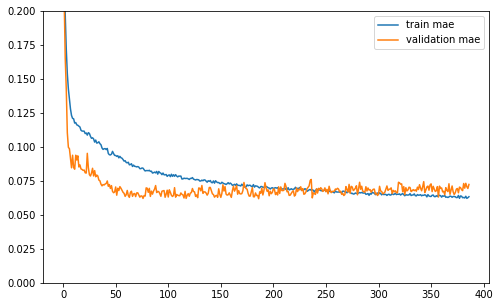

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='validation mae')
plt.ylim([0, 0.2])
plt.legend()
plt.show()

In [12]:
def plot_prediction(y_pred, y_true):
    plt.figure(figsize=(16,4))
    plt.plot(np.squeeze(y_pred), label='prediction')
    plt.plot(np.squeeze(y_true), label='true')
    plt.legend()
    plt.show()
    print('MAE: %.3f' % mean_absolute_error(np.squeeze(y_pred), np.squeeze(y_true)))

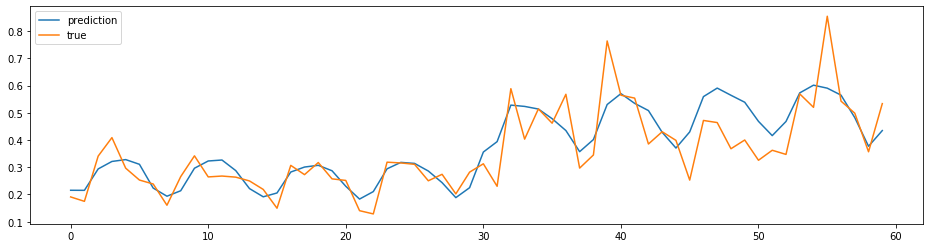

MAE: 0.062


In [14]:
pred = cnn.predict(X_val)
plot_prediction(pred, Y_val)

In [15]:
history = cnn.fit(X, Y, batch_size=32, epochs=500, verbose=2,
                     callbacks=[EarlyStopping(monitor='mae', patience=30, restore_best_weights=True)])

Epoch 1/500
11/11 - 0s - loss: 0.0096 - mae: 0.0715
Epoch 2/500
11/11 - 0s - loss: 0.0097 - mae: 0.0715
Epoch 3/500
11/11 - 0s - loss: 0.0098 - mae: 0.0721
Epoch 4/500
11/11 - 0s - loss: 0.0095 - mae: 0.0710
Epoch 5/500
11/11 - 0s - loss: 0.0096 - mae: 0.0710
Epoch 6/500
11/11 - 0s - loss: 0.0096 - mae: 0.0716
Epoch 7/500
11/11 - 0s - loss: 0.0098 - mae: 0.0718
Epoch 8/500
11/11 - 0s - loss: 0.0094 - mae: 0.0710
Epoch 9/500
11/11 - 0s - loss: 0.0096 - mae: 0.0711
Epoch 10/500
11/11 - 0s - loss: 0.0094 - mae: 0.0708
Epoch 11/500
11/11 - 0s - loss: 0.0097 - mae: 0.0717
Epoch 12/500
11/11 - 0s - loss: 0.0096 - mae: 0.0714
Epoch 13/500
11/11 - 0s - loss: 0.0095 - mae: 0.0711
Epoch 14/500
11/11 - 0s - loss: 0.0095 - mae: 0.0711
Epoch 15/500
11/11 - 0s - loss: 0.0094 - mae: 0.0707
Epoch 16/500
11/11 - 0s - loss: 0.0098 - mae: 0.0719
Epoch 17/500
11/11 - 0s - loss: 0.0093 - mae: 0.0702
Epoch 18/500
11/11 - 0s - loss: 0.0093 - mae: 0.0703
Epoch 19/500
11/11 - 0s - loss: 0.0093 - mae: 0.0700
Ep

Epoch 155/500
11/11 - 0s - loss: 0.0074 - mae: 0.0628
Epoch 156/500
11/11 - 0s - loss: 0.0075 - mae: 0.0631
Epoch 157/500
11/11 - 0s - loss: 0.0073 - mae: 0.0623
Epoch 158/500
11/11 - 0s - loss: 0.0071 - mae: 0.0618
Epoch 159/500
11/11 - 0s - loss: 0.0071 - mae: 0.0617
Epoch 160/500
11/11 - 0s - loss: 0.0071 - mae: 0.0615
Epoch 161/500
11/11 - 0s - loss: 0.0072 - mae: 0.0622
Epoch 162/500
11/11 - 0s - loss: 0.0073 - mae: 0.0622
Epoch 163/500
11/11 - 0s - loss: 0.0074 - mae: 0.0623
Epoch 164/500
11/11 - 0s - loss: 0.0071 - mae: 0.0616
Epoch 165/500
11/11 - 0s - loss: 0.0073 - mae: 0.0619
Epoch 166/500
11/11 - 0s - loss: 0.0074 - mae: 0.0627
Epoch 167/500
11/11 - 0s - loss: 0.0072 - mae: 0.0616
Epoch 168/500
11/11 - 0s - loss: 0.0073 - mae: 0.0623
Epoch 169/500
11/11 - 0s - loss: 0.0071 - mae: 0.0615
Epoch 170/500
11/11 - 0s - loss: 0.0074 - mae: 0.0625
Epoch 171/500
11/11 - 0s - loss: 0.0069 - mae: 0.0609
Epoch 172/500
11/11 - 0s - loss: 0.0075 - mae: 0.0630
Epoch 173/500
11/11 - 0s - l

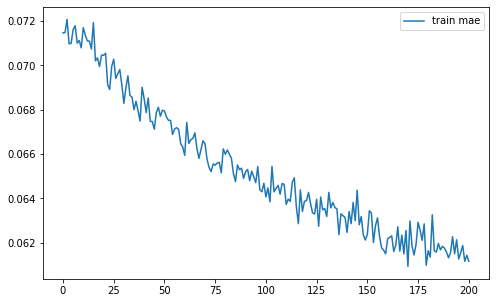

11/11 - 0s - loss: 0.0051 - mae: 0.0519
[0.005110139958560467, 0.05192216485738754]


In [16]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='train mae')
plt.legend()
plt.show()
print(cnn.evaluate(X, Y, verbose=2))

In [17]:
pred_tst = cnn.predict(X_tst)
pur_sep = scaler_pur.inverse_transform(pred_tst[:, :forward].transpose())
red_sep = scaler_red.inverse_transform(pred_tst[:, forward:].transpose())

In [18]:
test_user = pd.DataFrame({'report_date': [20140900 + i for i in range(1, 31)]})
test_user['pur'] = pur_sep.astype('int')
test_user['red'] = red_sep.astype('int')
test_user.to_csv('submission.csv', encoding='utf-8', index=None, header=None)